In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/aO (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input/face-expression-recognition-dataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/face-expression-recognition-dataset/images/validation/surprise/13288.jpg
/kaggle/input/face-expression-recognition-dataset/images/validation/surprise/24201.jpg
/kaggle/input/face-expression-recognition-dataset/images/validation/surprise/26556.jpg
/kaggle/input/face-expression-recognition-dataset/images/validation/surprise/26076.jpg
/kaggle/input/face-expression-recognition-dataset/images/validation/surprise/27577.jpg
/kaggle/input/face-expression-recognition-dataset/images/validation/surprise/27973.jpg
/kaggle/input/face-expression-recognition-dataset/images/validation/surprise/26452.jpg
/kaggle/input/face-expression-recognition-dataset/images/validation/surprise/10162.jpg
/kaggle/input/face-expression-recognition-dataset/images/validation/surprise/12768.jpg
/kaggle/input/face-expression-recognition-dataset/images/validation/surprise/12551.jpg
/kaggle/input/face-expression-recognition-dataset/images/validation/surprise/13205.jpg
/kaggle/input/face-expression-recognition-d

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
%%capture

# !pip3 install --upgrade pip
import os


os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

SIZE = 48
IMAGES_DIR = "/kaggle/input/face-expression-recognition-dataset/images/"

In [4]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, LSTM, Input
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, TimeDistributed
from tensorflow.keras.layers import LSTM, Bidirectional, Conv1D, concatenate, Permute, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, LSTM, Input, TimeDistributed
from tensorflow.keras.layers import BatchNormalization, Activation, Reshape
from tensorflow.keras.backend import transpose
from tensorflow.keras import backend as K 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


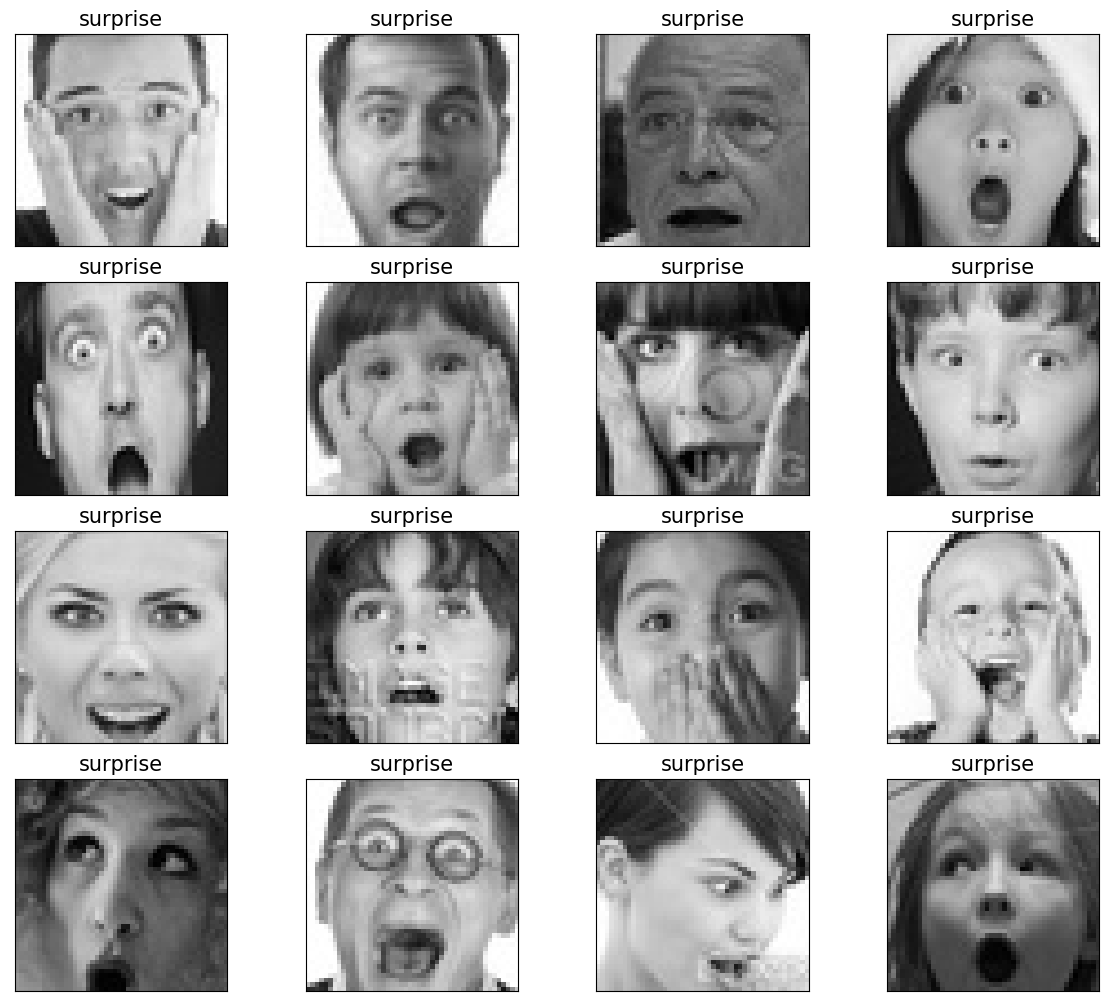

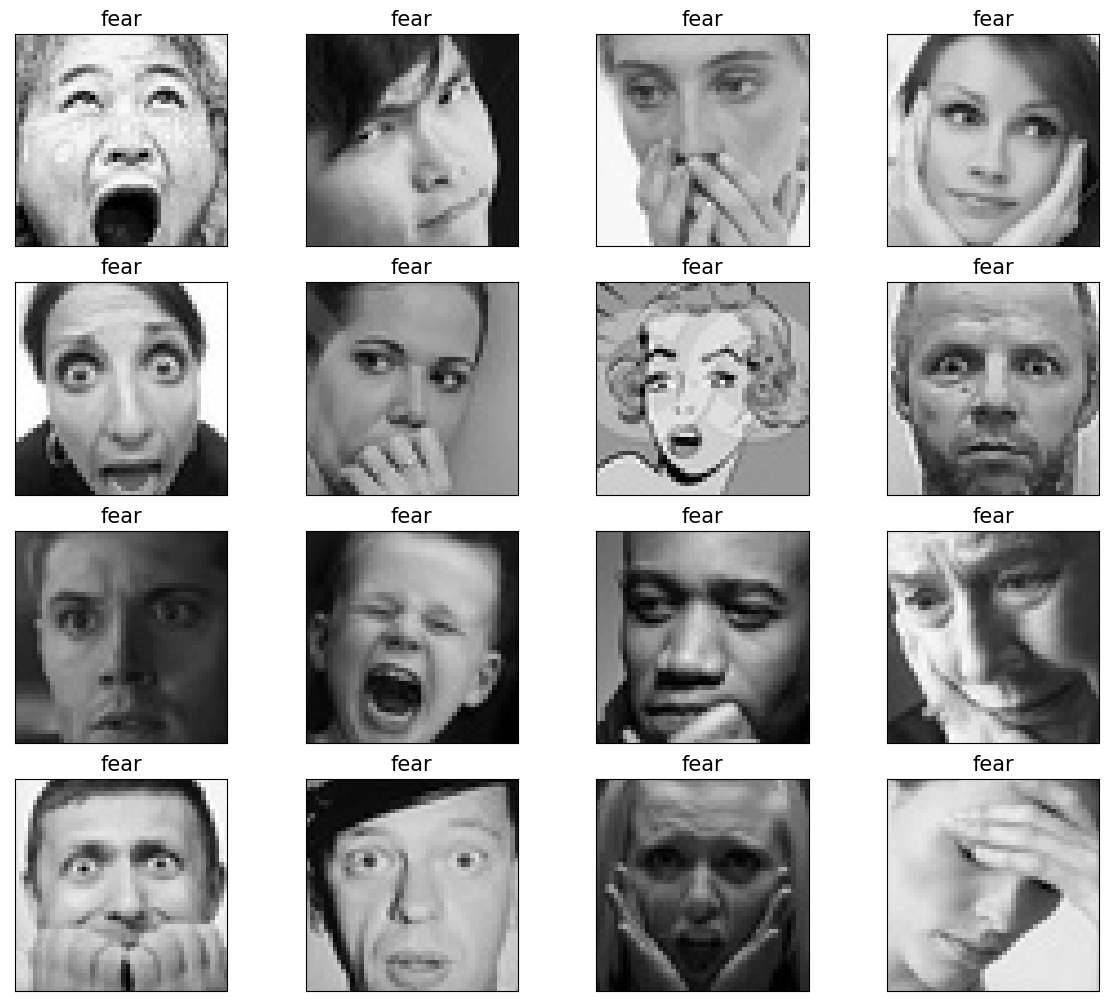

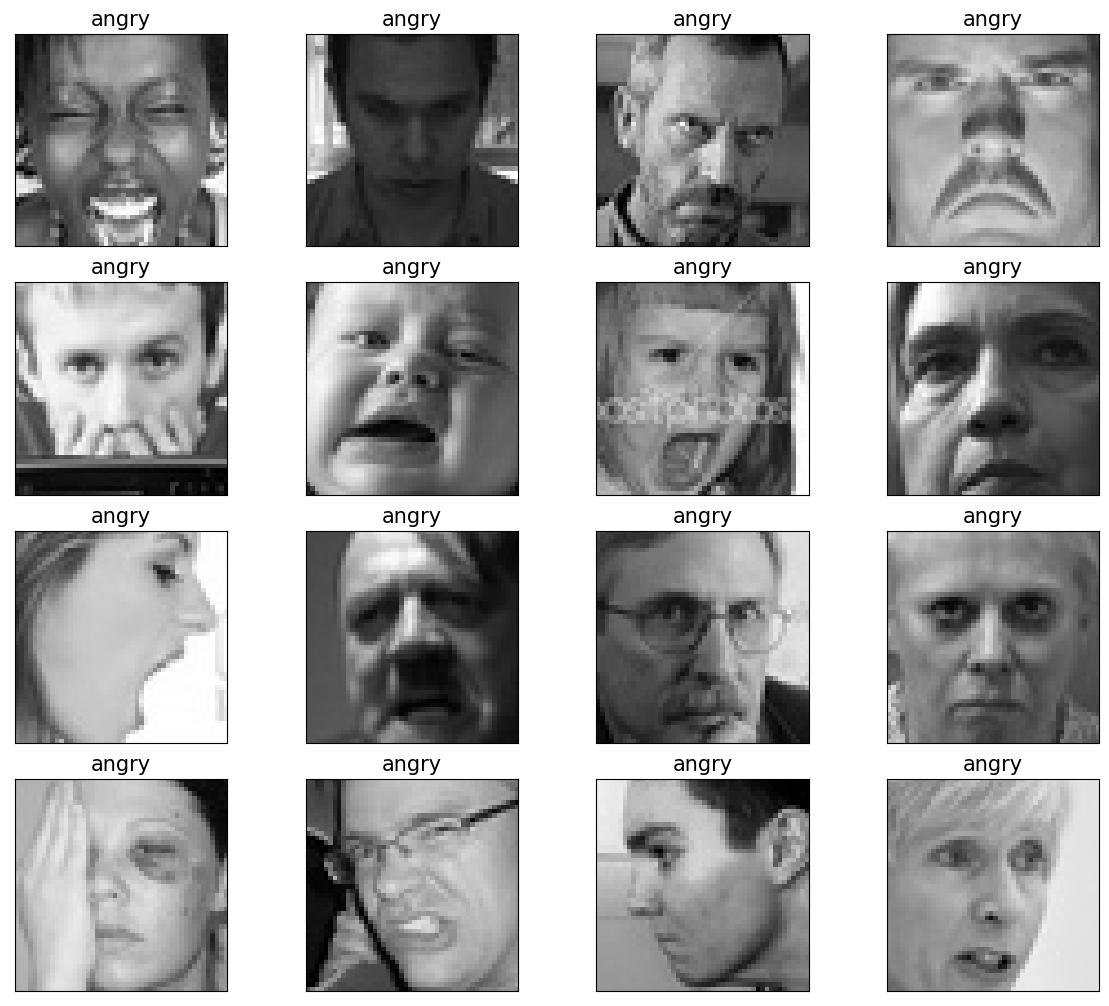

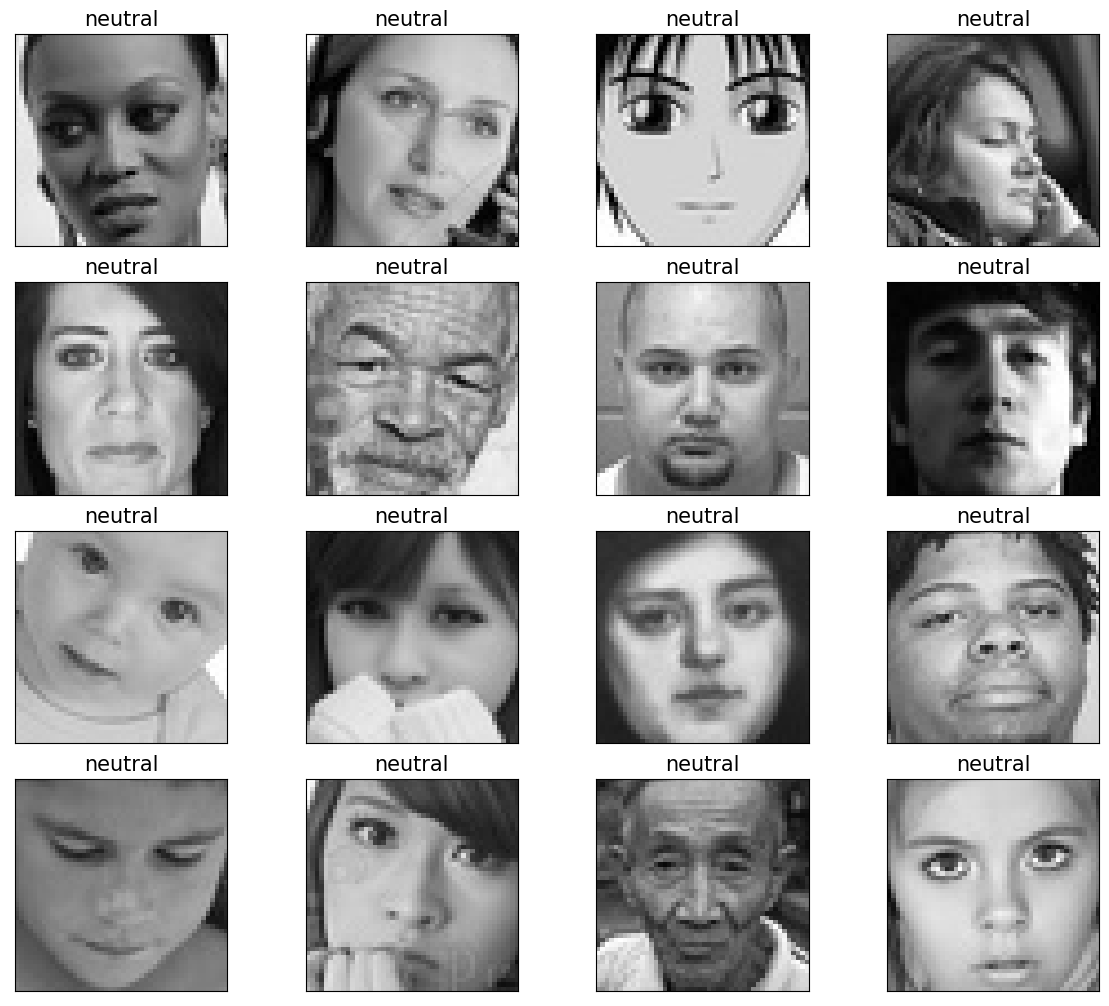

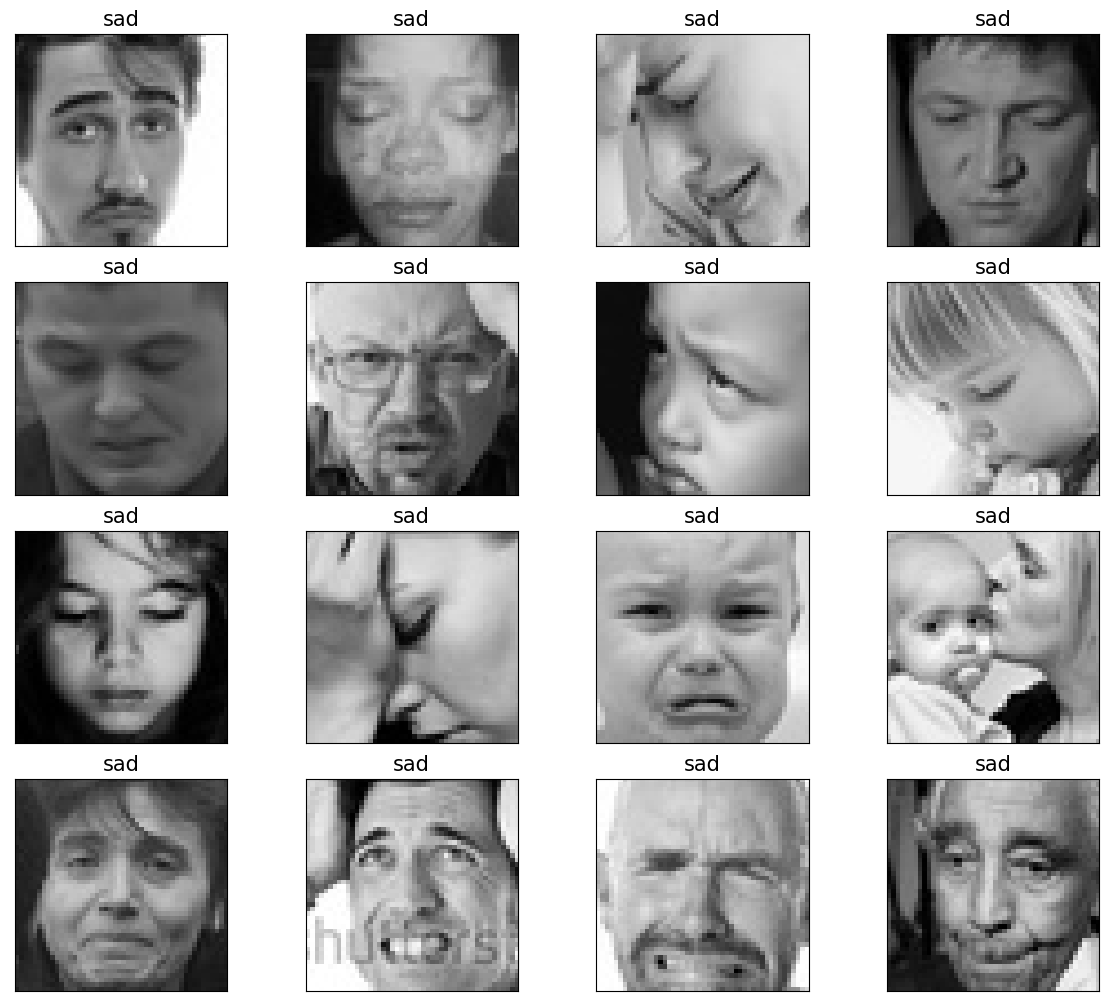

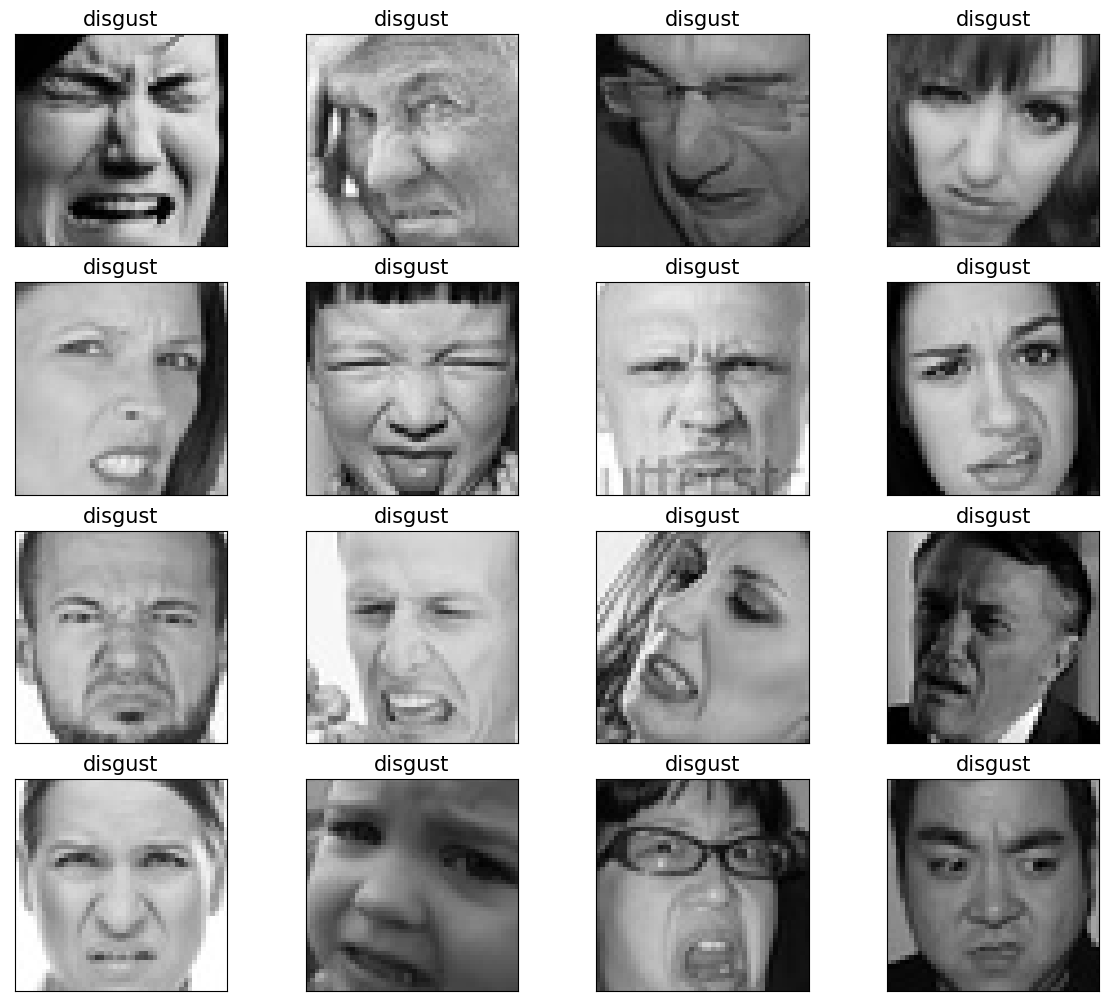

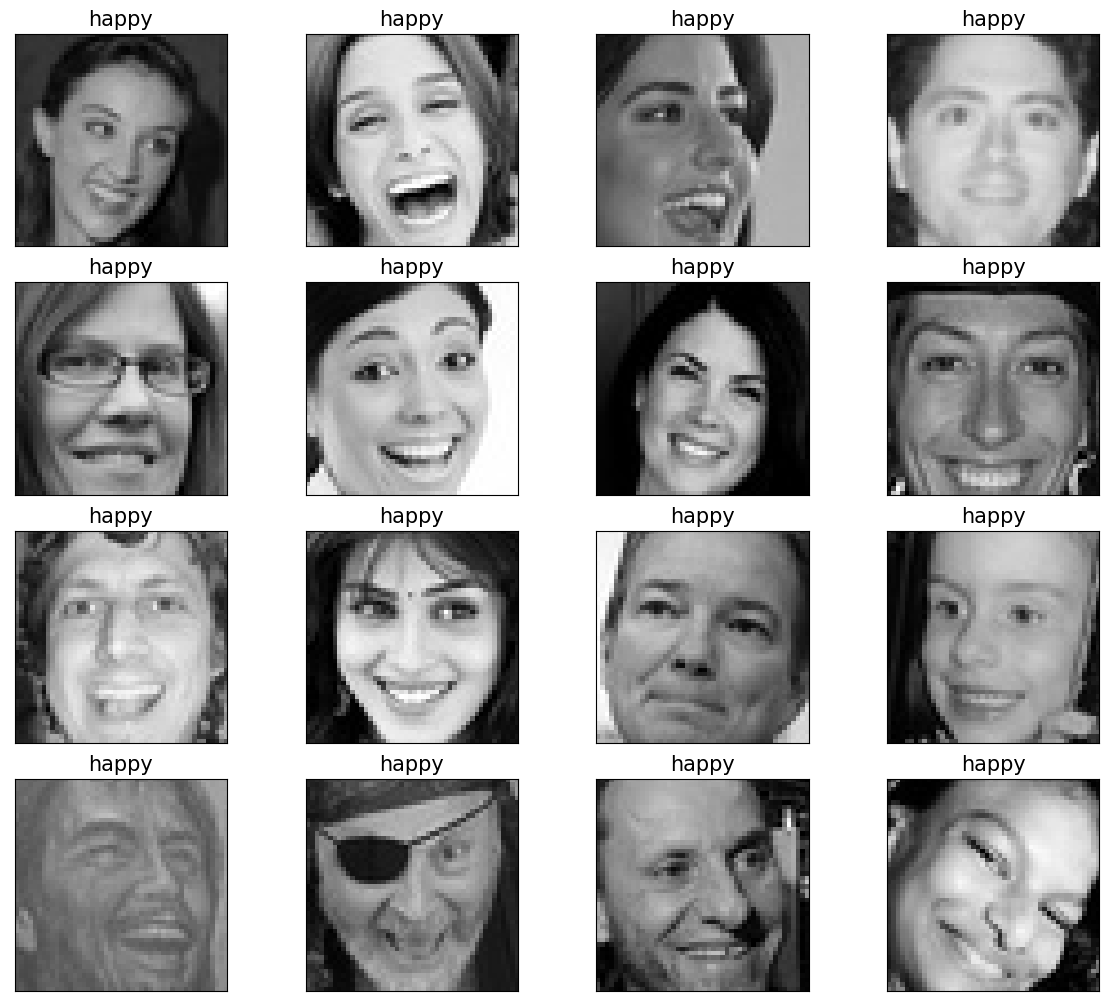

In [5]:
# Display some pictures of the dataset
for expression in os.listdir(os.path.join(IMAGES_DIR, 'train')):
    if not os.path.isdir(os.path.join(IMAGES_DIR, 'train', expression)):
        continue
    fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(12, 10),
                        subplot_kw={'xticks': [], 'yticks': []})
    for i, ax in enumerate(axes.flat):
        file = os.listdir(IMAGES_DIR + "train/" + expression)[i]
        fname = os.path.join(IMAGES_DIR, 'train', expression, file)
        img = load_img(fname)
        ax.imshow(img)
        title = expression
        ax.set_title(title, fontsize = 15)
    plt.tight_layout(pad=0.5)
    plt.show()

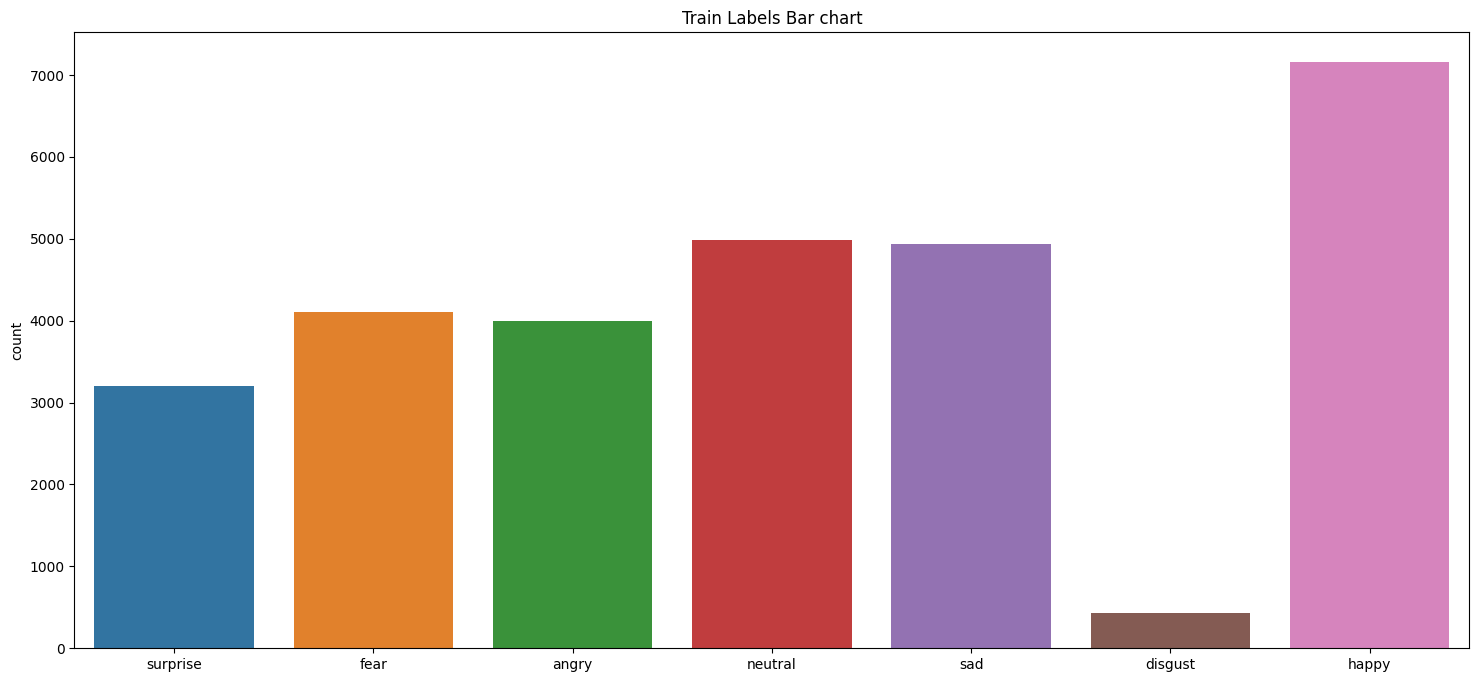

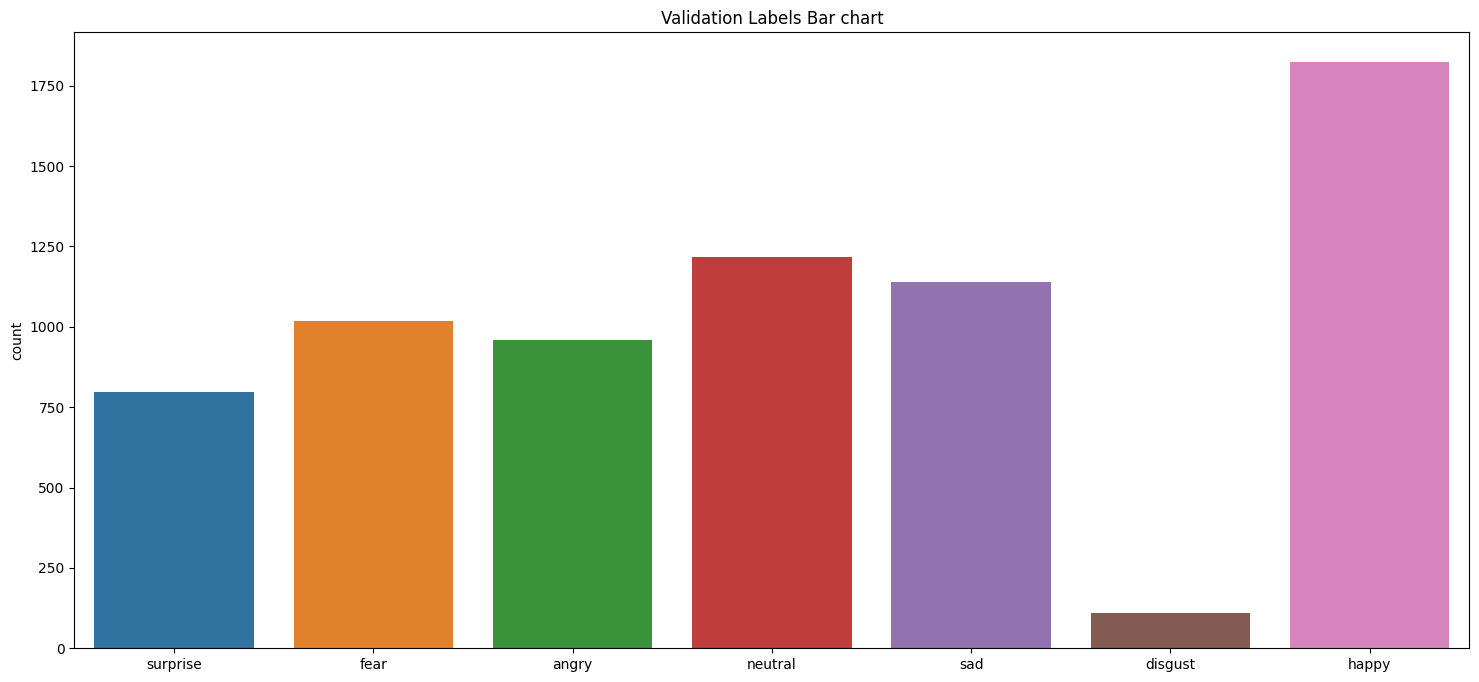

In [6]:
labels = []
for expression in os.listdir(os.path.join(IMAGES_DIR, 'train')):
    if not os.path.isdir(os.path.join(IMAGES_DIR, 'train', expression)):
        continue
    labels += [expression for _ in os.listdir(os.path.join(IMAGES_DIR, 'train', expression))]

plt.figure(figsize = (18, 8))
plt.title('Train Labels Bar chart')
sns.countplot(x=labels)

_ = plt.show()

labels = []
for expression in os.listdir(os.path.join(IMAGES_DIR, 'validation')):
    if not os.path.isdir(os.path.join(IMAGES_DIR, 'validation', expression)):
        continue
    labels += [expression for _ in os.listdir(os.path.join(IMAGES_DIR, 'validation', expression))]

plt.figure(figsize = (18, 8))
plt.title('Validation Labels Bar chart')
sns.countplot(x=labels)

_ = plt.show()

In [7]:
num_classes = 7
epochs = 120
batch_size  = 64
row_hidden = 64
col_hidden = 32

input_layer = Input(shape=(SIZE, SIZE, 1))
C_t = K.permute_dimensions(input_layer, (0, 3, 1, 2))

x0 = Reshape((-1, SIZE), input_shape=(SIZE, SIZE, 1))(C_t)
encoded_rows = Bidirectional(LSTM(row_hidden, return_sequences=True))(x0)


# Add stacked LSTM layers
for i in range(4):
    encoded_rows = LSTM(row_hidden, return_sequences=True)(encoded_rows)

x1 = LSTM(col_hidden)(encoded_rows)
x2 = Flatten()(x1)
x3 = Dense(64)(x2)
x4 = Dense(64)(x3)
output_layer = Dense(num_classes, activation="softmax")(x4)

model = Model(inputs=input_layer, outputs=output_layer)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 1)]       0         
                                                                 
 tf.compat.v1.transpose (TFO  (None, 1, 48, 48)        0         
 pLambda)                                                        
                                                                 
 reshape (Reshape)           (None, 48, 48)            0         
                                                                 
 bidirectional (Bidirectiona  (None, 48, 128)          57856     
 l)                                                              
                                                                 
 lstm_1 (LSTM)               (None, 48, 64)            49408     
                                                                 
 lstm_2 (LSTM)               (None, 48, 64)            33024 

In [8]:
datagen_train = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)
 
datagen_val = ImageDataGenerator(rescale=1. / 255)


train_set = datagen_train.flow_from_directory(os.path.join(IMAGES_DIR,  "train"),
                                              target_size = (SIZE, SIZE),
                                              color_mode = "grayscale",
                                              batch_size=batch_size,
                                              class_mode='categorical',
                                              shuffle=True)


test_set = datagen_val.flow_from_directory(os.path.join(IMAGES_DIR,  "validation"),
                                              target_size = (SIZE, SIZE),
                                              color_mode = "grayscale",
                                              batch_size=batch_size,
                                              class_mode='categorical',
                                              shuffle=False)

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


In [9]:
checkpoint = ModelCheckpoint("./model.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

early_stopping = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=10,
                          verbose=1,
                          restore_best_weights=True
                          )

reduce_learningrate = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=3,
                              verbose=1,
                              min_delta=0.001)

In [10]:
callbacks_list = [early_stopping,checkpoint,reduce_learningrate]


model.compile(loss='categorical_crossentropy',
              optimizer = Adam(learning_rate=0.0001),
              metrics=['accuracy'])



In [11]:
history = model.fit(train_set,
                    steps_per_epoch=96,
                    epochs=epochs,
                    validation_data=test_set,
                    validation_steps=test_set.n//test_set.batch_size,
                    callbacks=callbacks_list)


Epoch 1/120
96/96 [==============================] - ETA: 0s - loss: 1.8522 - accuracy: 0.2445
Epoch 1: val_accuracy improved from -inf to 0.25923, saving model to ./model.h5
96/96 [==============================] - 86s 777ms/step - loss: 1.8522 - accuracy: 0.2445 - val_loss: 1.8045 - val_accuracy: 0.2592 - lr: 1.0000e-04
Epoch 2/120
96/96 [==============================] - ETA: 0s - loss: 1.7940 - accuracy: 0.2520
Epoch 2: val_accuracy improved from 0.25923 to 0.26520, saving model to ./model.h5
96/96 [==============================] - 38s 391ms/step - loss: 1.7940 - accuracy: 0.2520 - val_loss: 1.7752 - val_accuracy: 0.2652 - lr: 1.0000e-04
Epoch 3/120
96/96 [==============================] - ETA: 0s - loss: 1.7821 - accuracy: 0.2542
Epoch 3: val_accuracy improved from 0.26520 to 0.27827, saving model to ./model.h5
96/96 [==============================] - 33s 347ms/step - loss: 1.7821 - accuracy: 0.2542 - val_loss: 1.7611 - val_accuracy: 0.2783 - lr: 1.0000e-04
Epoch 4/120
96/96 [===

In [12]:
model.load_weights("./model.h5")

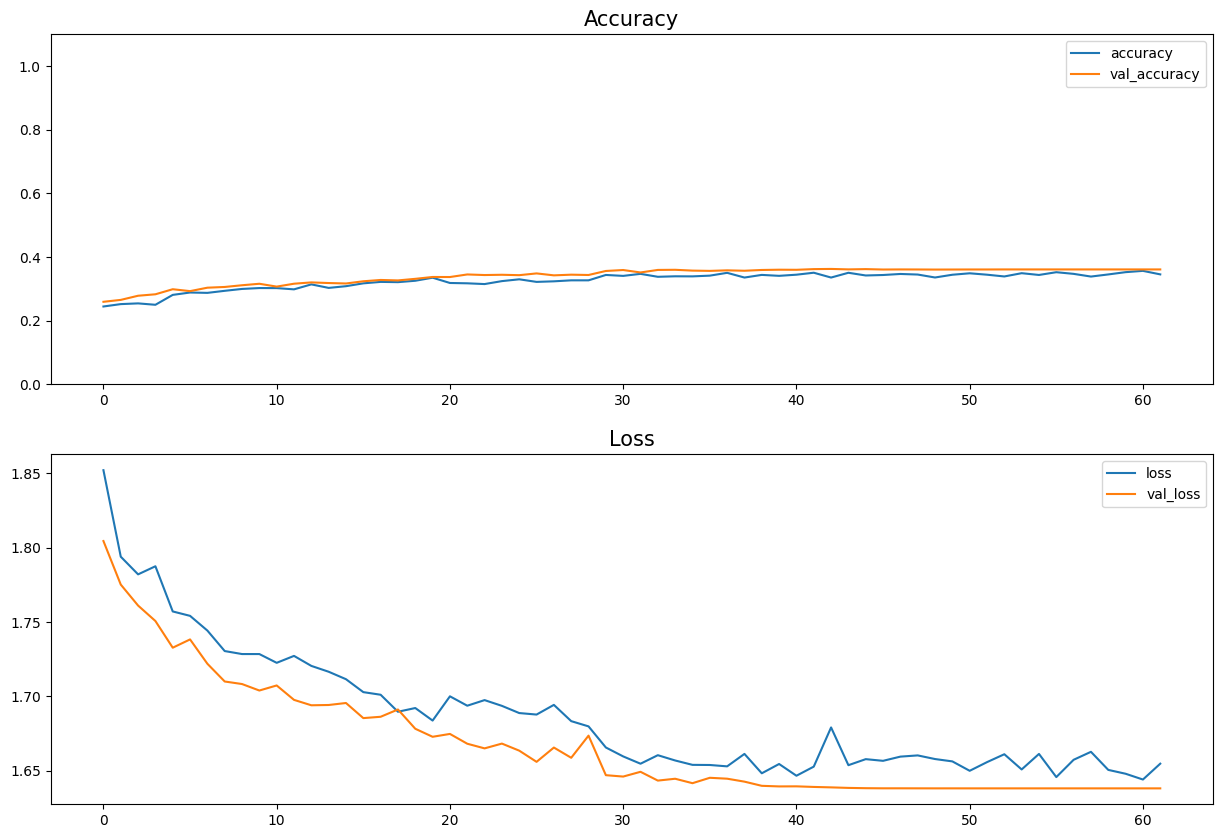

In [13]:
fig, axes = plt.subplots(2, 1, figsize=(15, 10))
ax = axes.flat

pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot(ax=ax[0])
ax[0].set_title("Accuracy", fontsize = 15)
ax[0].set_ylim(0,1.1)

pd.DataFrame(history.history)[['loss','val_loss']].plot(ax=ax[1])
ax[1].set_title("Loss", fontsize = 15)
plt.show()

In [14]:
from keras.models import load_model
from sklearn.metrics import accuracy_score

In [15]:
# Predict the label of the test_images
pred = model.predict_generator(test_set)
pred = np.argmax(pred,axis=1)

y_test = []
for i, (_, batch_y) in enumerate(test_set):
    if i >= len(test_set):
        break
    y_test.append(batch_y)
y_test = np.argmax(np.concatenate(y_test, axis=0),axis=1)
# Get the accuracy score
acc = accuracy_score(y_test, pred)

# Display the results
print(f'{acc*100:.2f}% accuracy on the test set')

36.29% accuracy on the test set


In [16]:
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.21      0.05      0.08       960
           1       0.00      0.00      0.00       111
           2       0.23      0.06      0.09      1018
           3       0.42      0.70      0.53      1825
           4       0.32      0.34      0.33      1216
           5       0.29      0.33      0.31      1139
           6       0.39      0.49      0.44       797

    accuracy                           0.36      7066
   macro avg       0.27      0.28      0.25      7066
weighted avg       0.32      0.36      0.32      7066



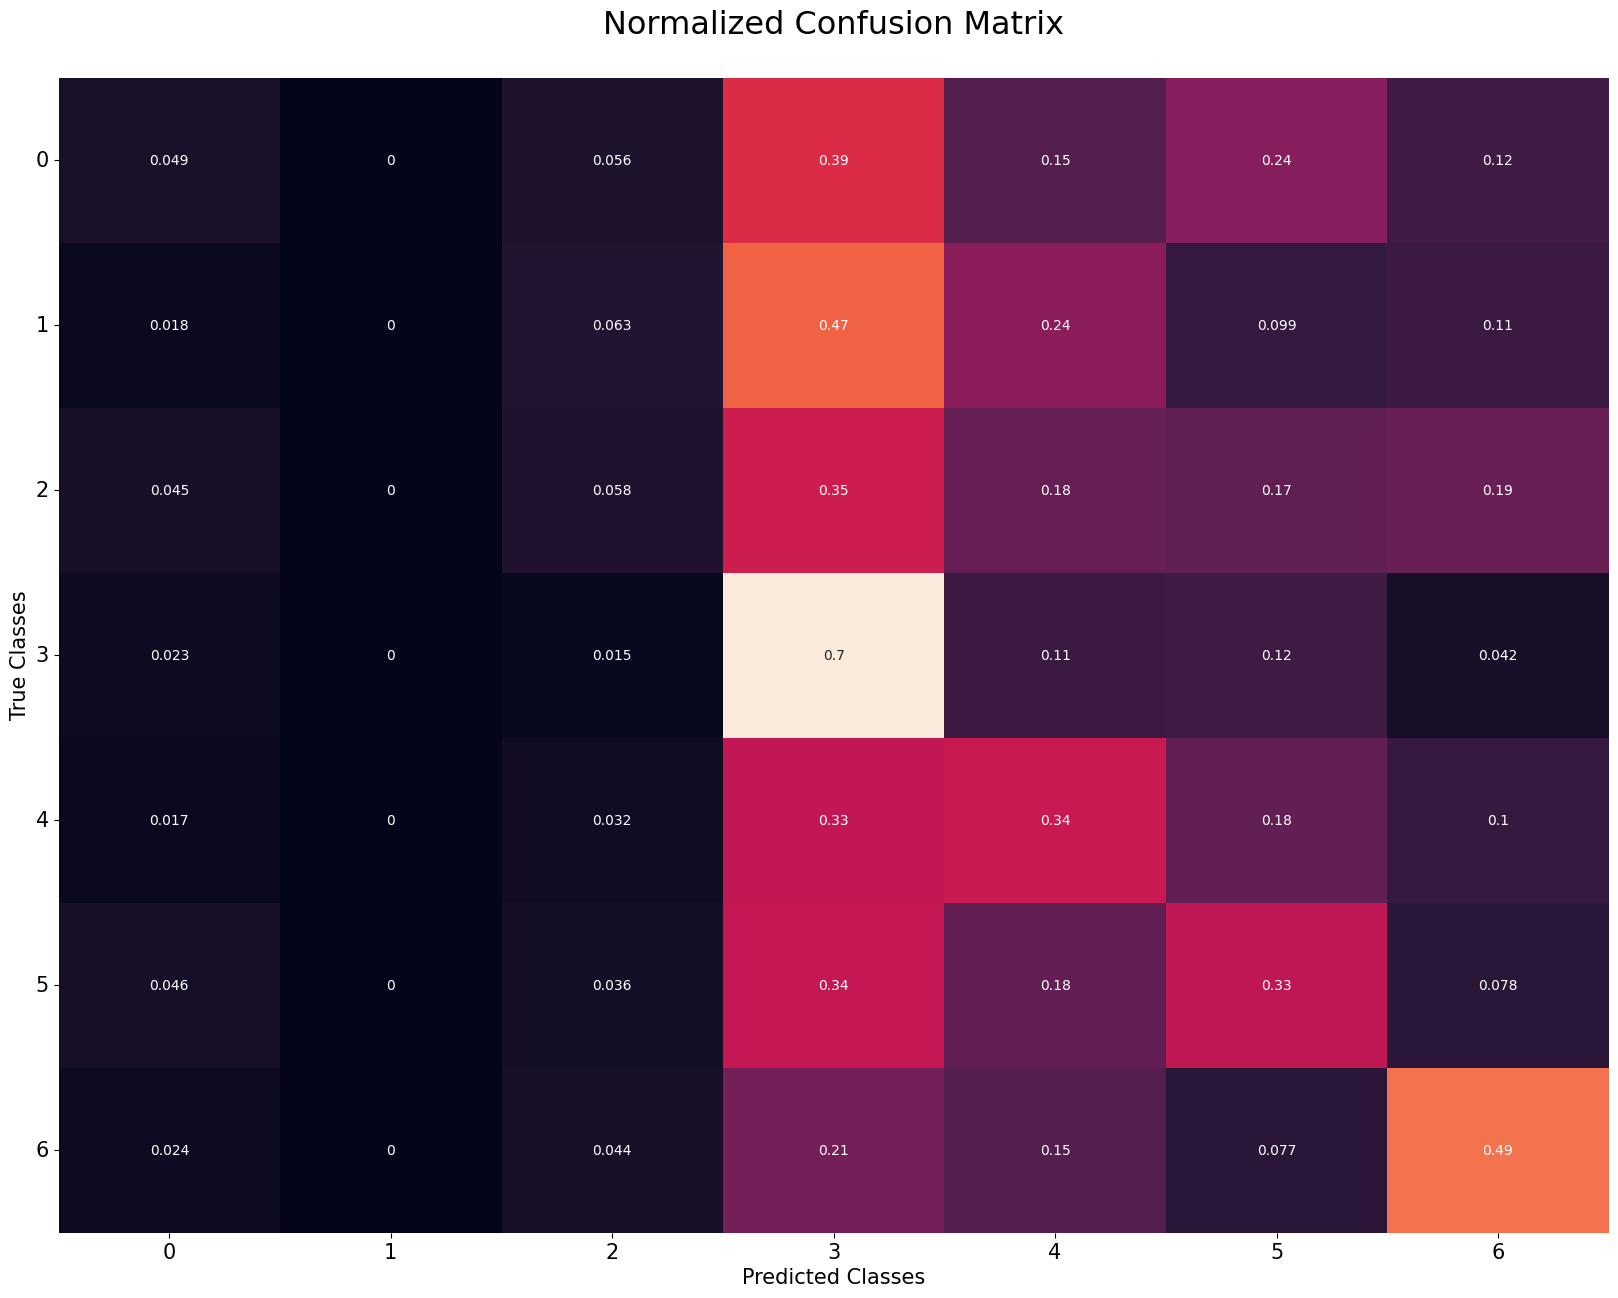

In [17]:
cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (20,15))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)),cbar=False)
plt.title('Normalized Confusion Matrix\n', fontsize = 23)
plt.xlabel("Predicted Classes",fontsize=15)
plt.ylabel("True Classes",fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15,rotation=0)
plt.show()

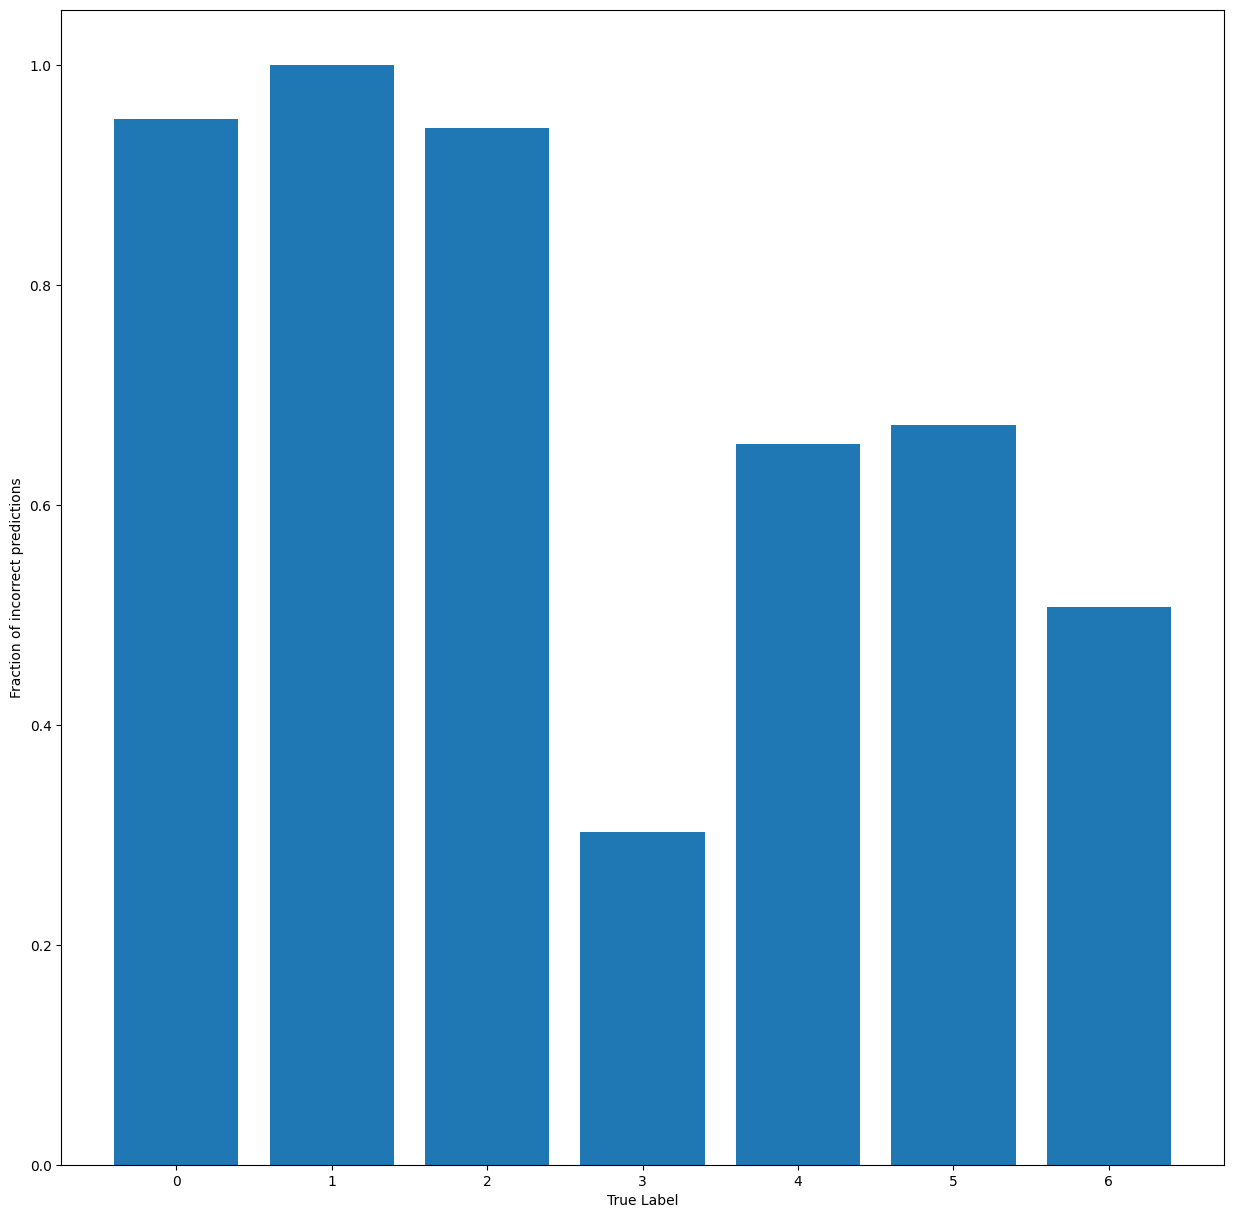

In [18]:
incorr_fraction = 1 - np.diag(cf_matrix) / np.sum(cf_matrix, axis=1)
fig, ax = plt.subplots(figsize=(15,15))
plt.bar(np.arange(num_classes), incorr_fraction)
plt.xlabel('True Label')
plt.ylabel('Fraction of incorrect predictions')
plt.xticks(np.arange(num_classes), sorted(set(y_test)))

_ = plt.show()

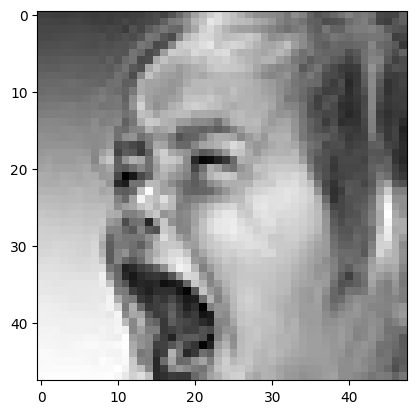

[1. 0. 0. 0. 0. 0. 0.]


In [19]:
import matplotlib.pyplot as plt

# Get a batch of images from the test set
images, labels = next(test_set)

# Plot the first image in the batch
plt.imshow(images[0].reshape(SIZE, SIZE), cmap="gray")
plt.show()

# Print the label of the first image
print(labels[0])


In [20]:
# Predict the label of the test images
pred = model.predict_generator(test_set)
pred = np.argmax(pred,axis=1)

# Get the true labels of the test images
y_test = []
for i, (_, batch_y) in enumerate(test_set):
    if i >= len(test_set):
        break
    y_test.append(batch_y)
y_test = np.argmax(np.concatenate(y_test, axis=0),axis=1)

# Calculate the accuracy score
acc = accuracy_score(y_test, pred)
print(f'Accuracy score: {acc*100:.2f}%')

# Calculate other evaluation metrics like precision, recall, and F1-score
report = classification_report(y_test, pred)
print(report)


Accuracy score: 34.36%
              precision    recall  f1-score   support

           0       0.17      0.04      0.06       960
           1       0.00      0.00      0.00       111
           2       0.21      0.06      0.09      1018
           3       0.41      0.68      0.51      1825
           4       0.30      0.33      0.31      1216
           5       0.28      0.32      0.30      1139
           6       0.34      0.43      0.38       797

    accuracy                           0.34      7066
   macro avg       0.25      0.26      0.24      7066
weighted avg       0.30      0.34      0.30      7066



111/111 [==============================] - 8s 73ms/step


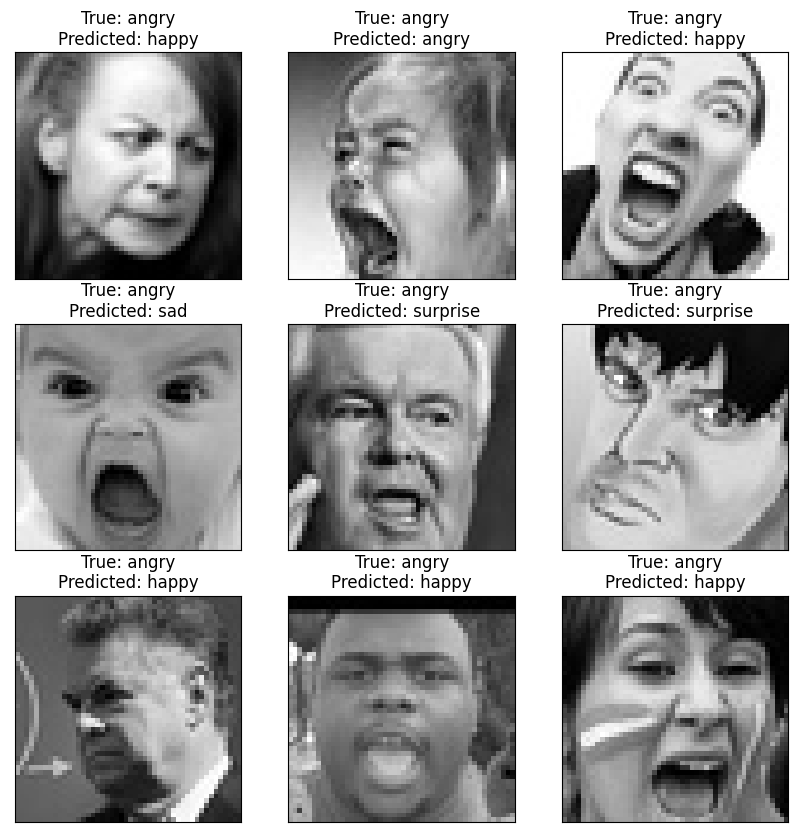

In [21]:
import matplotlib.pyplot as plt

# Predict the labels of the test images
pred = model.predict(test_set)

# Get the true labels of the test images
y_true = test_set.classes

# Get the class labels of the predictions
class_labels = list(test_set.class_indices.keys())

# Plot some of the test images along with their predicted and true labels
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    ax.imshow(test_set[i][0][0], cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f"True: {class_labels[y_true[i]]}\nPredicted: {class_labels[pred[i].argmax()]}")
    if i == 8:
        break
plt.show()


In [22]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Assuming you have already trained the model and have the test data ready

# Extract features from the last Dense layer
extract_features_model = Model(inputs=model.input, outputs=model.layers[-2].output)

# Extract features from the training set
train_features = extract_features_model.predict(train_set)

# Reshape the features to be compatible with Random Forest
train_features = train_features.reshape(train_features.shape[0], -1)

# Extract features from the test set
test_features = extract_features_model.predict(test_set)
test_features = test_features.reshape(test_features.shape[0], -1)

# Train-Test Split
X_train, X_val, y_train, y_val = train_test_split(train_features, train_set.labels, test_size=0.2, random_state=42)

# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier()

# Train the model
rf_classifier.fit(X_train, y_train)

# Make predictions
y_pred = rf_classifier.predict(X_val)

# Evaluate the model
accuracy = accuracy_score(y_val, y_pred)
print("Accuracy: ", accuracy)


111/111 [==============================] - 9s 77ms/step
Accuracy:  0.20693842150910668
